In [1]:
import pandas as pd
import numpy as np
from utils import load_train_sparse
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
matrix = train_matrix = load_train_sparse('/h/u15/c2/01/huan3264/PycharmProjects/CSC311Project/code_starter/starter/data/').toarray()

In [3]:
total_nan = np.isnan(matrix).sum()

# Display the total number of NaN values
print(f"Total number of NaN values: {total_nan}")
print(total_nan/(542 * 1774))


Total number of NaN values: 904820
0.9410426122299554


In [4]:
def question_correlation_matrix(A, C_S):
    """Compute the Question Correlation Matrix C_Q using the Assignment Matrix A and Subject Correlation Matrix C_S.

    :param A: 2D NumPy array representing the Question-Subject Assignment Matrix
    :param C_S: 2D NumPy array representing the Subject Correlation Matrix
    :return: 2D NumPy array representing the Question Correlation Matrix
    """
    # Compute the Question Correlation Matrix C_Q = A * C_S * A^T
    C_Q = np.dot(np.dot(A, C_S), A.T)  # Shape: [Q, Q]

    # Normalize C_Q to ensure similarity scores are between 0 and 1
    # Compute the diagonal elements of C_Q
    C_Q_diag = np.diag(C_Q)  # Shape: [Q]

    # Compute normalization matrix
    normalization_matrix = np.sqrt(
        np.outer(C_Q_diag, C_Q_diag))  # Shape: [Q, Q]

    # Avoid division by zero by replacing zeros with a small epsilon
    epsilon = 1e-8
    normalization_matrix[normalization_matrix == 0] = epsilon

    # Normalize C_Q
    C_Q_normalized = C_Q / normalization_matrix

    # Replace any NaN values resulting from division by zero with zero
    C_Q_normalized = np.nan_to_num(C_Q_normalized)

    # Set diagonal entries to 1
    np.fill_diagonal(C_Q_normalized, 1.0)

    # Clip values to [0, 1]
    C_Q_normalized = np.clip(C_Q_normalized, 0, 1)

    return C_Q_normalized


def parse_subjects(subjects_str):
    """
    Safely parse the subjects list from a string.
    Handles formats like "[1,2]" or "1,2".
    """
    try:
        # Attempt to parse as a list
        subjects = ast.literal_eval(subjects_str)
        if isinstance(subjects, list):
            return subjects
    except:
        pass
    # If not a list, split by comma and convert to integers
    return [int(s.strip()) for s in subjects_str.split(',') if
                s.strip().isdigit()]


def get_correlation_matrix(base_path="./data"):
    # Load subject metadata
    subject_meta = pd.read_csv(f'{base_path}/subject_meta.csv')

    # Load question metadata
    question_meta = pd.read_csv(f'{base_path}/question_meta.csv')

    question_meta['subjects'] = question_meta['subject_id'].apply(
        parse_subjects)

    # Construct the Question-Subject Assignment Matrix A
    unique_subjects = subject_meta['subject_id'].unique()
    unique_subjects_sorted = np.sort(unique_subjects)
    num_questions = question_meta.shape[0]
    num_subjects = unique_subjects_sorted.shape[0]

    # Initialize the assignment matrix with zeros
    A = np.zeros((num_questions, num_subjects), dtype=int)

    # Populate the assignment matrix
    for idx, row in question_meta.iterrows():
        question_idx = idx  # Assuming question_meta is indexed from 0 to Q-1
        subjects = row['subjects']
        for s in subjects:
            # Find the column index for subject s
            if s in unique_subjects_sorted:
                subject_col = np.where(unique_subjects_sorted == s)[0][0]
                A[question_idx, subject_col] = 1

    # Compute the Subject Correlation Matrix C_S using cosine similarity on TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(subject_meta['name'])
    C_S = cosine_similarity(tfidf_matrix, tfidf_matrix)  # Shape: [S, S]

    return question_correlation_matrix(A, C_S)

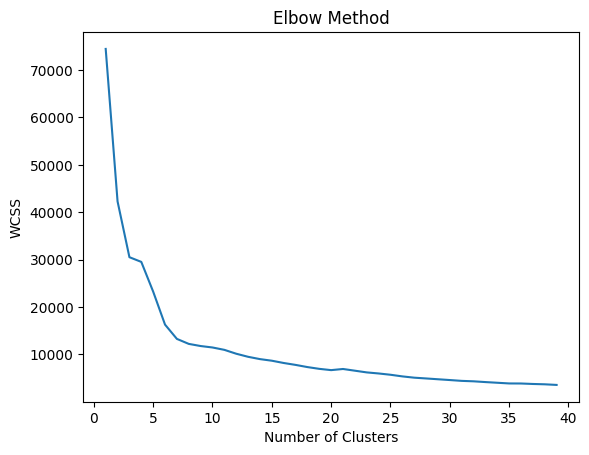

In [6]:
C_Q_normalized = get_correlation_matrix(base_path="./data")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(C_Q_normalized)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

plt.plot(range(1, 40), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  
plt.title('Elbow Method')
plt.show()


In [14]:
from sklearn.metrics import silhouette_score

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(C_Q_normalized)
    score = silhouette_score(C_Q_normalized, labels)
    print(f"k={k}, Silhouette Score: {score}")


k=2, Silhouette Score: 0.4011055409119137
k=3, Silhouette Score: 0.4318893954813566
k=4, Silhouette Score: 0.3652453153516907
k=5, Silhouette Score: 0.35102325207815216
k=6, Silhouette Score: 0.42567527637238456
k=7, Silhouette Score: 0.4563770704343127
k=8, Silhouette Score: 0.4212514909346456
k=9, Silhouette Score: 0.41766951989520307
k=10, Silhouette Score: 0.42604300198200257
k=11, Silhouette Score: 0.38816332442186546
k=12, Silhouette Score: 0.4220709943774519
k=13, Silhouette Score: 0.4383814791886144
k=14, Silhouette Score: 0.4554185128234699


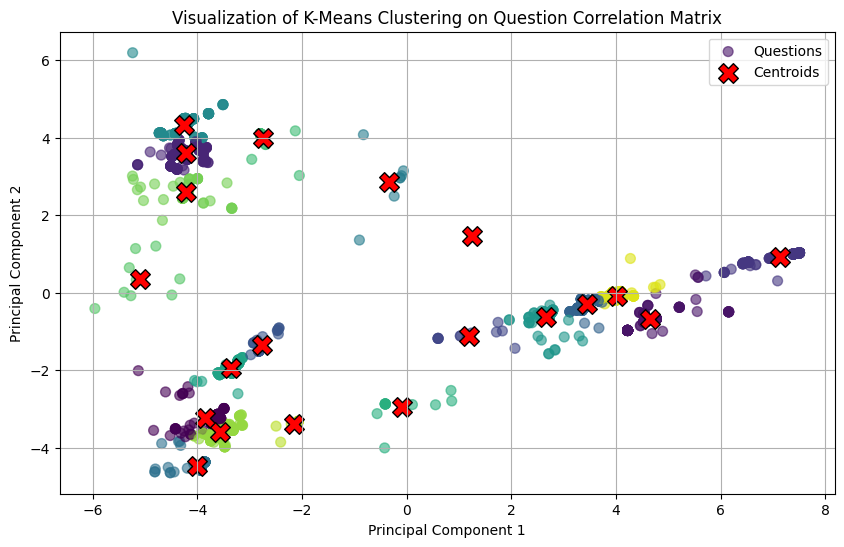

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume C_Q_normalized is your correlation matrix
# Example: C_Q_normalized = np.random.rand(100, 100)  # Replace this with your actual matrix

# Step 1: Dimensionality Reduction with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
C_Q_reduced = pca.fit_transform(C_Q_normalized)

# Step 2: Apply k-means clustering
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(C_Q_reduced)
labels = kmeans.predict(C_Q_reduced)
centroids = kmeans.cluster_centers_

# Step 3: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(C_Q_reduced[:, 0], C_Q_reduced[:, 1], c=labels, s=50, cmap='viridis', marker='o', alpha=0.6, label='Questions')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', edgecolor='black', label='Centroids')
plt.title('Visualization of K-Means Clustering on Question Correlation Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()
